In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 128
use_gpu = True
y_scale = True
lr = 0.001
weight_decay = 0.01

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2, step3])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.transform(X_test)
print(X_test.shape)

(60000, 211)
(10000, 211)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [13]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 211])
torch.Size([10000, 211])
torch.Size([42000, 1])


In [15]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [16]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(211, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x

In [17]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [18]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    with torch.no_grad():
        pred = model(X)
        
        pred = pred.cpu().numpy()
        if y_scale:
            pred = y_scaler.inverse_transform(pred)            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [19]:
train_losses = []
eval_losses = []
accs = []
for t in range(10000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 0.006422948999483263
epochs 1
training loss 0.006056437275222415
epochs 2
training loss 0.005955726137217757
epochs 3
training loss 0.005924502837381079
epochs 4
training loss 0.006277736624041827
epochs 5
training loss 0.006030793773083973
epochs 6
training loss 0.006059891003251959
epochs 7
training loss 0.006257857825878815
epochs 8
training loss 0.005982358165023039
epochs 9
training loss 0.005898672602589506
testing loss 0.006586242181493352
epochs 10
training loss 0.005731636897510761
epochs 11
training loss 0.005884248715553625
epochs 12
training loss 0.005533632614627186
epochs 13
training loss 0.005711548329376273
epochs 14
training loss 0.006669217080874284
epochs 15
training loss 0.005856510948483184
epochs 16
training loss 0.006216286153654288
epochs 17
training loss 0.005692190414940015
epochs 18
training loss 0.005463047924743099
epochs 19
training loss 0.005867086382056261
testing loss 0.006552166852056451
epochs 20
training loss 0.0061041566742850

training loss 0.0027233960954783807
epochs 169
training loss 0.0027581296222833605
testing loss 0.0042424650577141355
epochs 170
training loss 0.0026018049188968823
epochs 171
training loss 0.002980002699247179
epochs 172
training loss 0.002668383235457186
epochs 173
training loss 0.002765183173202114
epochs 174
training loss 0.004876679575953938
epochs 175
training loss 0.004794421551273542
epochs 176
training loss 0.0030135858254110876
epochs 177
training loss 0.002789724679057993
epochs 178
training loss 0.0028353250857250127
epochs 179
training loss 0.002764203759776513
testing loss 0.004066234575881762
epochs 180
training loss 0.0027109768601151405
epochs 181
training loss 0.0026370697894691287
epochs 182
training loss 0.0026171024670077086
epochs 183
training loss 0.002647003864318891
epochs 184
training loss 0.0027316019128679685
epochs 185
training loss 0.005141002611514736
epochs 186
training loss 0.005166740900140516
epochs 187
training loss 0.005038837179694449
epochs 188
tr

training loss 0.0020020364456042918
epochs 333
training loss 0.001796187228051872
epochs 334
training loss 0.0019078500815497366
epochs 335
training loss 0.0019062020406155284
epochs 336
training loss 0.0018578090030547108
epochs 337
training loss 0.002007585023473212
epochs 338
training loss 0.0020858582918104746
epochs 339
training loss 0.0020240078519925043
testing loss 0.0033767699315179643
epochs 340
training loss 0.0018445150093401932
epochs 341
training loss 0.001914908492012023
epochs 342
training loss 0.0023207621424923166
epochs 343
training loss 0.001969863182941514
epochs 344
training loss 0.001984429577546687
epochs 345
training loss 0.002049470943997481
epochs 346
training loss 0.0019165005688456462
epochs 347
training loss 0.0018994603219362808
epochs 348
training loss 0.0016763520085233006
epochs 349
training loss 0.0016841168887276304
testing loss 0.0038239846405645848
epochs 350
training loss 0.0018654193574885376
epochs 351
training loss 0.001717621518056953
epochs 3

training loss 0.0013351092434567499
epochs 497
training loss 0.0012991619977525415
epochs 498
training loss 0.0013447703218999062
epochs 499
training loss 0.0012971121381888998
testing loss 0.002892412863678385
epochs 500
training loss 0.0013041076298851214
epochs 501
training loss 0.0014777582994730163
epochs 502
training loss 0.0013453922438644733
epochs 503
training loss 0.0013960146208613613
epochs 504
training loss 0.0013014569607532177
epochs 505
training loss 0.0012522327522945373
epochs 506
training loss 0.0013231396302510064
epochs 507
training loss 0.001951981367370663
epochs 508
training loss 0.001512841234128005
epochs 509
training loss 0.001467362535079958
testing loss 0.00282765128889207
epochs 510
training loss 0.0012773909548716479
epochs 511
training loss 0.0013154740809777179
epochs 512
training loss 0.0013003581661573897
epochs 513
training loss 0.0012811567309867352
epochs 514
training loss 0.0013454427670526084
epochs 515
training loss 0.0012711646866143927
epochs 

training loss 0.0010751800503338317
epochs 661
training loss 0.0012028558194951513
epochs 662
training loss 0.0018358253351961882
epochs 663
training loss 0.001378572732245544
epochs 664
training loss 0.0010836949951643843
epochs 665
training loss 0.0010345911847407672
epochs 666
training loss 0.0010516446232045561
epochs 667
training loss 0.001039309507288254
epochs 668
training loss 0.0012883972491584946
epochs 669
training loss 0.0010879093446375344
testing loss 0.002758517685092008
epochs 670
training loss 0.0009870680916338232
epochs 671
training loss 0.002810838858923934
epochs 672
training loss 0.0031954053404392806
epochs 673
training loss 0.0019855968435478926
epochs 674
training loss 0.0019842086628427597
epochs 675
training loss 0.0018107463744763386
epochs 676
training loss 0.00121372898224611
epochs 677
training loss 0.0010909268310177493
epochs 678
training loss 0.0010461961209355063
epochs 679
training loss 0.0010410719425530714
testing loss 0.002677970714883628
epochs 6

training loss 0.0008869761276259837
epochs 825
training loss 0.0009543409542390075
epochs 826
training loss 0.000979508055422857
epochs 827
training loss 0.000901377989166051
epochs 828
training loss 0.0009363567682002928
epochs 829
training loss 0.0009454109263323292
testing loss 0.002725618794405212
epochs 830
training loss 0.0008944745513817187
epochs 831
training loss 0.0009800448658448676
epochs 832
training loss 0.001001008883657183
epochs 833
training loss 0.0009236761351472678
epochs 834
training loss 0.0010111248523165333
epochs 835
training loss 0.0009634698352615114
epochs 836
training loss 0.0016898249164874748
epochs 837
training loss 0.0009200754602854409
epochs 838
training loss 0.0008829865826854318
epochs 839
training loss 0.0009479247013957588
testing loss 0.002791658214356169
epochs 840
training loss 0.0017693227657334918
epochs 841
training loss 0.0009794234028185143
epochs 842
training loss 0.0008946456068894602
epochs 843
training loss 0.0010264947937729295
epochs

training loss 0.000794802245943691
epochs 988
training loss 0.00154733580928494
epochs 989
training loss 0.0009357797024038403
testing loss 0.00287671233296183
epochs 990
training loss 0.0008418446420522061
epochs 991
training loss 0.0008143752087601163
epochs 992
training loss 0.001051147389303508
epochs 993
training loss 0.0008121635358799023
epochs 994
training loss 0.0009051123797634508
epochs 995
training loss 0.0008453434046766916
epochs 996
training loss 0.0008467804075439537
epochs 997
training loss 0.0007869362691169644
epochs 998
training loss 0.0007861161492708334
epochs 999
training loss 0.0008316069746200324
testing loss 0.002733445537676176
epochs 1000
training loss 0.0008180473707680022
epochs 1001
training loss 0.0009089020938233198
epochs 1002
training loss 0.0007738178389962185
epochs 1003
training loss 0.0008182158044540808
epochs 1004
training loss 0.0011540430739145487
epochs 1005
training loss 0.0014429391123988527
epochs 1006
training loss 0.0015928491643604492
e

training loss 0.0008034291429484779
epochs 1148
training loss 0.0007911463361693473
epochs 1149
training loss 0.0007978769201122927
testing loss 0.002926002571554128
epochs 1150
training loss 0.0008508239290323165
epochs 1151
training loss 0.0008182178359722158
epochs 1152
training loss 0.0008176115961068828
epochs 1153
training loss 0.0008344069484367933
epochs 1154
training loss 0.0007810243745093831
epochs 1155
training loss 0.000777401452555709
epochs 1156
training loss 0.0008034620115230579
epochs 1157
training loss 0.0010240014190792664
epochs 1158
training loss 0.0009514290868979808
epochs 1159
training loss 0.0018202618532672547
testing loss 0.002946083727441332
epochs 1160
training loss 0.0016664515603630943
epochs 1161
training loss 0.0009626124236778013
epochs 1162
training loss 0.0008198676254362502
epochs 1163
training loss 0.0009910998673823672
epochs 1164
training loss 0.0008184867303310341
epochs 1165
training loss 0.0007981352456229652
epochs 1166
training loss 0.00083

training loss 0.0006950906443191653
epochs 1308
training loss 0.0007746165562038929
epochs 1309
training loss 0.0007327322232095372
testing loss 0.00276921101282714
epochs 1310
training loss 0.0013044314182258712
epochs 1311
training loss 0.0011338531467808824
epochs 1312
training loss 0.0007291051699273221
epochs 1313
training loss 0.0007571576631664777
epochs 1314
training loss 0.000647805995445155
epochs 1315
training loss 0.000672515596356526
epochs 1316
training loss 0.0007691435406365259
epochs 1317
training loss 0.0007090762654414236
epochs 1318
training loss 0.0008821242520236056
epochs 1319
training loss 0.0008100949487532843
testing loss 0.0026514048313272865
epochs 1320
training loss 0.000739757067578389
epochs 1321
training loss 0.0007092184195185992
epochs 1322
training loss 0.0007045755258727378
epochs 1323
training loss 0.000715260824636559
epochs 1324
training loss 0.0007606679582501277
epochs 1325
training loss 0.0007343267089380149
epochs 1326
training loss 0.00074354

training loss 0.000775423813041577
epochs 1468
training loss 0.0008255649867749243
epochs 1469
training loss 0.0008619040747754853
testing loss 0.0027158659167013112
epochs 1470
training loss 0.000791953069491929
epochs 1471
training loss 0.0007573924400513895
epochs 1472
training loss 0.0007682090697174546
epochs 1473
training loss 0.0007630222957187805
epochs 1474
training loss 0.0007760879054833996
epochs 1475
training loss 0.000777765151624933
epochs 1476
training loss 0.0007784343772216794
epochs 1477
training loss 0.0008193059190315135
epochs 1478
training loss 0.000792662651663063
epochs 1479
training loss 0.0007634058212196189
testing loss 0.002777142879546534
epochs 1480
training loss 0.000709946746856546
epochs 1481
training loss 0.0007943966724778211
epochs 1482
training loss 0.0007687312626742721
epochs 1483
training loss 0.0007421980788195251
epochs 1484
training loss 0.000817605942179163
epochs 1485
training loss 0.0007466953093862574
epochs 1486
training loss 0.000782254

training loss 0.0006686362996449733
epochs 1628
training loss 0.0006859241779553944
epochs 1629
training loss 0.0006875066313288234
testing loss 0.002773967174010629
epochs 1630
training loss 0.0006744776516098325
epochs 1631
training loss 0.0007370000110307884
epochs 1632
training loss 0.0006995522420666546
epochs 1633
training loss 0.0007268004581165191
epochs 1634
training loss 0.0007356929119165398
epochs 1635
training loss 0.000672085785061421
epochs 1636
training loss 0.000621855358195443
epochs 1637
training loss 0.0006722151492878025
epochs 1638
training loss 0.0008363247886024087
epochs 1639
training loss 0.0008066142282921447
testing loss 0.0027772133347598164
epochs 1640
training loss 0.0007105520438108491
epochs 1641
training loss 0.0006474690794191778
epochs 1642
training loss 0.0006378064823576099
epochs 1643
training loss 0.0006505879623062433
epochs 1644
training loss 0.0006965844650288597
epochs 1645
training loss 0.0007593954086557064
epochs 1646
training loss 0.00162

training loss 0.0007317757074215865
epochs 1788
training loss 0.0007380391709049343
epochs 1789
training loss 0.0007221823333342217
testing loss 0.0028642900469745937
epochs 1790
training loss 0.0008873144084358401
epochs 1791
training loss 0.0008576978856094725
epochs 1792
training loss 0.0007130909590991808
epochs 1793
training loss 0.0007830251051264455
epochs 1794
training loss 0.0008284597008136642
epochs 1795
training loss 0.0007845605539559956
epochs 1796
training loss 0.0007358885217687302
epochs 1797
training loss 0.0007808572088303129
epochs 1798
training loss 0.0017149721950435542
epochs 1799
training loss 0.0011954933375199425
testing loss 0.002848380694829641
epochs 1800
training loss 0.0009132883349422218
epochs 1801
training loss 0.0007536682618023278
epochs 1802
training loss 0.0007775765021882193
epochs 1803
training loss 0.0006816724245754951
epochs 1804
training loss 0.0007044576867632172
epochs 1805
training loss 0.0006624258160138202
epochs 1806
training loss 0.000

training loss 0.0009028676244087721
epochs 1948
training loss 0.0007872708271134441
epochs 1949
training loss 0.0007393911247719136
testing loss 0.0026609098348033397
epochs 1950
training loss 0.0007345142402214856
epochs 1951
training loss 0.0006738898687037756
epochs 1952
training loss 0.0006851796109454372
epochs 1953
training loss 0.0006717134852352974
epochs 1954
training loss 0.0007167860819062212
epochs 1955
training loss 0.0007339458233934451
epochs 1956
training loss 0.0006948776274571326
epochs 1957
training loss 0.000695705800218151
epochs 1958
training loss 0.0007964908036560465
epochs 1959
training loss 0.0006709406307175201
testing loss 0.002589173056845758
epochs 1960
training loss 0.0007484129046714131
epochs 1961
training loss 0.0006705802618695769
epochs 1962
training loss 0.0006524307621815624
epochs 1963
training loss 0.0007392911884104295
epochs 1964
training loss 0.000637792413088275
epochs 1965
training loss 0.0007147126871629655
epochs 1966
training loss 0.00062

training loss 0.0007178892066920216
epochs 2108
training loss 0.0006615048452028523
epochs 2109
training loss 0.0006604244011471269
testing loss 0.0028501458830160506
epochs 2110
training loss 0.0006302479661804395
epochs 2111
training loss 0.0006324545773826143
epochs 2112
training loss 0.0006187266784636616
epochs 2113
training loss 0.0007783337704990184
epochs 2114
training loss 0.0006510283394418034
epochs 2115
training loss 0.0006542867181382473
epochs 2116
training loss 0.0006309800942663363
epochs 2117
training loss 0.0006197490439237885
epochs 2118
training loss 0.0006569625565988835
epochs 2119
training loss 0.0007231005960735733
testing loss 0.0026884591417446575
epochs 2120
training loss 0.0007212931758407107
epochs 2121
training loss 0.0006724565750268206
epochs 2122
training loss 0.0005976901862750504
epochs 2123
training loss 0.0006517523038147957
epochs 2124
training loss 0.0006456531099140033
epochs 2125
training loss 0.0006322022857417645
epochs 2126
training loss 0.00

training loss 0.0006395481563297789
epochs 2268
training loss 0.0005817448105174753
epochs 2269
training loss 0.0006350281529445597
testing loss 0.0027067925399565634
epochs 2270
training loss 0.0006353202247889543
epochs 2271
training loss 0.0005942338144853937
epochs 2272
training loss 0.0005901470490395853
epochs 2273
training loss 0.0006416961340174238
epochs 2274
training loss 0.000584642333120085
epochs 2275
training loss 0.000667179823838214
epochs 2276
training loss 0.0006564515848052448
epochs 2277
training loss 0.0006504858750920731
epochs 2278
training loss 0.0006416006020651026
epochs 2279
training loss 0.0005983270236431114
testing loss 0.0027794436789414984
epochs 2280
training loss 0.0005789264161875726
epochs 2281
training loss 0.0006252348171419671
epochs 2282
training loss 0.0011949632712250637
epochs 2283
training loss 0.0007145558206129559
epochs 2284
training loss 0.0006379377546983468
epochs 2285
training loss 0.000595977990856213
epochs 2286
training loss 0.00065

training loss 0.0006617132423404537
epochs 2428
training loss 0.0005745273423140534
epochs 2429
training loss 0.0005917076208440468
testing loss 0.0028474660122152816
epochs 2430
training loss 0.0006199946283259483
epochs 2431
training loss 0.0005638350889732138
epochs 2432
training loss 0.0005980109598481954
epochs 2433
training loss 0.0006113787639729034
epochs 2434
training loss 0.0005821349044609249
epochs 2435
training loss 0.0006479676114041415
epochs 2436
training loss 0.0006165951975171191
epochs 2437
training loss 0.0006802969325212111
epochs 2438
training loss 0.0006303371803900143
epochs 2439
training loss 0.0006549588984372462
testing loss 0.0028616869025401346
epochs 2440
training loss 0.0006214183564849855
epochs 2441
training loss 0.0006072302916834533
epochs 2442
training loss 0.0006628929799080099
epochs 2443
training loss 0.0007023367287533069
epochs 2444
training loss 0.0007926908602632333
epochs 2445
training loss 0.0007950577578481887
epochs 2446
training loss 0.00

training loss 0.0008141536044988691
epochs 2588
training loss 0.000657595713526622
epochs 2589
training loss 0.0006899808485366653
testing loss 0.0027425258584710247
epochs 2590
training loss 0.0007655908605565054
epochs 2591
training loss 0.0007890535097096489
epochs 2592
training loss 0.0008411475311820381
epochs 2593
training loss 0.0009673101919325278
epochs 2594
training loss 0.0007637150261528495
epochs 2595
training loss 0.0007754878948993222
epochs 2596
training loss 0.0006294016880945707
epochs 2597
training loss 0.000704157714378853
epochs 2598
training loss 0.0005920377754929015
epochs 2599
training loss 0.000684194535188275
testing loss 0.002701906856819855
epochs 2600
training loss 0.0006157937748032115
epochs 2601
training loss 0.0006598582346909495
epochs 2602
training loss 0.0006452596856608115
epochs 2603
training loss 0.0007596192806272691
epochs 2604
training loss 0.0006384455518744671
epochs 2605
training loss 0.0006734541613618506
epochs 2606
training loss 0.000696

training loss 0.0008129589492278202
epochs 2748
training loss 0.0007217850164215909
epochs 2749
training loss 0.0006644009116408627
testing loss 0.002857895283167191
epochs 2750
training loss 0.0006543390907907694
epochs 2751
training loss 0.0006306897031460354
epochs 2752
training loss 0.00064927248288113
epochs 2753
training loss 0.0006266294806147572
epochs 2754
training loss 0.000583774075449917
epochs 2755
training loss 0.0006585813379219499
epochs 2756
training loss 0.0006198895890633703
epochs 2757
training loss 0.0007099963253644213
epochs 2758
training loss 0.0006196274910239633
epochs 2759
training loss 0.000705719802413266
testing loss 0.002932163547387624
epochs 2760
training loss 0.0006908007270598495
epochs 2761
training loss 0.0006696796491437826
epochs 2762
training loss 0.0005705528101730967
epochs 2763
training loss 0.0006184108513032332
epochs 2764
training loss 0.0006051921429173415
epochs 2765
training loss 0.0006128218668791831
epochs 2766
training loss 0.00058785

training loss 0.0006436267598761432
epochs 2908
training loss 0.0006258439429749743
epochs 2909
training loss 0.0006197605412637413
testing loss 0.002816512451279274
epochs 2910
training loss 0.0006403297615466826
epochs 2911
training loss 0.0006302974670191259
epochs 2912
training loss 0.000593653373883069
epochs 2913
training loss 0.0006402982700521291
epochs 2914
training loss 0.0006100299627849929
epochs 2915
training loss 0.0006079465008587053
epochs 2916
training loss 0.0006139618985066162
epochs 2917
training loss 0.0006041865241020284
epochs 2918
training loss 0.0006052566931786802
epochs 2919
training loss 0.000632605494543525
testing loss 0.002898435396512191
epochs 2920
training loss 0.0006882469783718259
epochs 2921
training loss 0.0006635952974446004
epochs 2922
training loss 0.0005989236258944117
epochs 2923
training loss 0.0006063772110858689
epochs 2924
training loss 0.0006459946422144137
epochs 2925
training loss 0.0005911295597673617
epochs 2926
training loss 0.000592

training loss 0.0005756406484866702
epochs 3068
training loss 0.0005806404894669356
epochs 3069
training loss 0.0005771500883994788
testing loss 0.002761631655830441
epochs 3070
training loss 0.0006711885694337947
epochs 3071
training loss 0.0006148324705947667
epochs 3072
training loss 0.00059362059615844
epochs 3073
training loss 0.0006978673049061924
epochs 3074
training loss 0.0006101815411070855
epochs 3075
training loss 0.0005933301019805023
epochs 3076
training loss 0.0005880951383193576
epochs 3077
training loss 0.0006113170603138754
epochs 3078
training loss 0.000589519974856643
epochs 3079
training loss 0.0005769783501459517
testing loss 0.002838620217104198
epochs 3080
training loss 0.0005927887978032231
epochs 3081
training loss 0.0006933961519023183
epochs 3082
training loss 0.0006064478625362246
epochs 3083
training loss 0.0006609939940706869
epochs 3084
training loss 0.0005993269844614762
epochs 3085
training loss 0.0006102708521819925
epochs 3086
training loss 0.0005791

training loss 0.000578146157177635
epochs 3228
training loss 0.0006079823017547807
epochs 3229
training loss 0.0007697775627176439
testing loss 0.0029283543695292785
epochs 3230
training loss 0.0005852847214909214
epochs 3231
training loss 0.0006614387498731162
epochs 3232
training loss 0.0005769433035610079
epochs 3233
training loss 0.0006865987861684685
epochs 3234
training loss 0.0006277957536799601
epochs 3235
training loss 0.0005758534217257574
epochs 3236
training loss 0.0005678561071852523
epochs 3237
training loss 0.0005749116229221768
epochs 3238
training loss 0.0006778570580102311
epochs 3239
training loss 0.0006871878427430693
testing loss 0.002821804770658202
epochs 3240
training loss 0.0005726614771665592
epochs 3241
training loss 0.0005929863600889759
epochs 3242
training loss 0.0005719152536267262
epochs 3243
training loss 0.000583945853511115
epochs 3244
training loss 0.0006405603854299883
epochs 3245
training loss 0.0005798308926458983
epochs 3246
training loss 0.00074

training loss 0.0007169523799549902
epochs 3388
training loss 0.0006811322795975908
epochs 3389
training loss 0.0006544840834202602
testing loss 0.002715631501653384
epochs 3390
training loss 0.0005810496462424113
epochs 3391
training loss 0.0005996547369385495
epochs 3392
training loss 0.0006038910262767894
epochs 3393
training loss 0.0005904548323081982
epochs 3394
training loss 0.0006027130692621189
epochs 3395
training loss 0.0006043876482897062
epochs 3396
training loss 0.0006430598348626828
epochs 3397
training loss 0.0006830927305133012
epochs 3398
training loss 0.0006490643718279898
epochs 3399
training loss 0.0005693586155210301
testing loss 0.002793170681804524
epochs 3400
training loss 0.0005763493772698028
epochs 3401
training loss 0.0005581589090308078
epochs 3402
training loss 0.0006314576707856792
epochs 3403
training loss 0.0005856677761554752
epochs 3404
training loss 0.0005687053528002896
epochs 3405
training loss 0.000763557455714758
epochs 3406
training loss 0.00067

training loss 0.0006180277515675499
epochs 3548
training loss 0.0005950507920909118
epochs 3549
training loss 0.0006935129235470299
testing loss 0.0030080147053722743
epochs 3550
training loss 0.0011556180920112187
epochs 3551
training loss 0.0006723235759177842
epochs 3552
training loss 0.0006145532755145809
epochs 3553
training loss 0.0005520854162449996
epochs 3554
training loss 0.000506183583948246
epochs 3555
training loss 0.0005670535618065655
epochs 3556
training loss 0.0005554073280725617
epochs 3557
training loss 0.0005801362043004597
epochs 3558
training loss 0.0005550209670270988
epochs 3559
training loss 0.000533965403248774
testing loss 0.002714116136619412
epochs 3560
training loss 0.0005627103211106251
epochs 3561
training loss 0.00055323625238199
epochs 3562
training loss 0.0005289282179848039
epochs 3563
training loss 0.000525515046894924
epochs 3564
training loss 0.0005229226858277259
epochs 3565
training loss 0.0005529915460485875
epochs 3566
training loss 0.00068630

training loss 0.0007120528841167575
epochs 3708
training loss 0.0006759037840637268
epochs 3709
training loss 0.0007238997112252639
testing loss 0.002544318044274147
epochs 3710
training loss 0.0005992964863894638
epochs 3711
training loss 0.0007000166506507918
epochs 3712
training loss 0.0006820363645253584
epochs 3713
training loss 0.0007109137240119312
epochs 3714
training loss 0.0007482770804562082
epochs 3715
training loss 0.0007774787215448032
epochs 3716
training loss 0.0007497229346917733
epochs 3717
training loss 0.0005642706064767796
epochs 3718
training loss 0.0006808482260354101
epochs 3719
training loss 0.0009359633565086328
testing loss 0.0029108478482944744
epochs 3720
training loss 0.0006240027067449657
epochs 3721
training loss 0.0007047444012470396
epochs 3722
training loss 0.0005405153544891433
epochs 3723
training loss 0.000642554404208363
epochs 3724
training loss 0.0005657597301466996
epochs 3725
training loss 0.0005093251708307584
epochs 3726
training loss 0.0006

training loss 0.0008790927508663341
epochs 3868
training loss 0.000811785838664382
epochs 3869
training loss 0.0008419305997289219
testing loss 0.002634064994541043
epochs 3870
training loss 0.0008421936839370278
epochs 3871
training loss 0.0007951962191888943
epochs 3872
training loss 0.0008281622208318019
epochs 3873
training loss 0.0008827279476480032
epochs 3874
training loss 0.0008512136880605621
epochs 3875
training loss 0.000849750499884346
epochs 3876
training loss 0.0008536200769780639
epochs 3877
training loss 0.0008411266246356217
epochs 3878
training loss 0.0008210112261309891
epochs 3879
training loss 0.0008840240683374037
testing loss 0.002538709367083795
epochs 3880
training loss 0.0008321648041114755
epochs 3881
training loss 0.0008269300884078893
epochs 3882
training loss 0.0008300928331559133
epochs 3883
training loss 0.0007902439265252914
epochs 3884
training loss 0.0008317419123626384
epochs 3885
training loss 0.0008456568816806951
epochs 3886
training loss 0.000803

training loss 0.0010508150196673863
epochs 4028
training loss 0.0016437548382199259
epochs 4029
training loss 0.0010533381977449751
testing loss 0.0027121432176758107
epochs 4030
training loss 0.0008390825056919607
epochs 4031
training loss 0.0007637609671242252
epochs 4032
training loss 0.0007110263992703907
epochs 4033
training loss 0.0006848759369784542
epochs 4034
training loss 0.0007901556401882932
epochs 4035
training loss 0.0008036272474147073
epochs 4036
training loss 0.0007530696355521192
epochs 4037
training loss 0.0006518803431976609
epochs 4038
training loss 0.0006896703472002877
epochs 4039
training loss 0.0006189930447699973
testing loss 0.0026343930388820617
epochs 4040
training loss 0.0005987547717950984
epochs 4041
training loss 0.0005934583083344312
epochs 4042
training loss 0.0005961024199929485
epochs 4043
training loss 0.0005791026622617453
epochs 4044
training loss 0.0005565204726260348
epochs 4045
training loss 0.0005841501328547833
epochs 4046
training loss 0.00

training loss 0.0004621964341841955
epochs 4188
training loss 0.0005136856826596913
epochs 4189
training loss 0.000492288328804172
testing loss 0.00251078255043583
epochs 4190
training loss 0.0005017190901484725
epochs 4191
training loss 0.0005670343170092528
epochs 4192
training loss 0.0004902618918971281
epochs 4193
training loss 0.0005506381664409565
epochs 4194
training loss 0.0006575042759259387
epochs 4195
training loss 0.0005289743909906698
epochs 4196
training loss 0.0005401296164779598
epochs 4197
training loss 0.0005044838727457522
epochs 4198
training loss 0.0004951117277544524
epochs 4199
training loss 0.0005359033040035697
testing loss 0.0026715069006903905
epochs 4200
training loss 0.0005344069880606057
epochs 4201
training loss 0.0005009394079959162
epochs 4202
training loss 0.0005280530688106606
epochs 4203
training loss 0.0004954763862770051
epochs 4204
training loss 0.0005158828000862174
epochs 4205
training loss 0.0005745037132767977
epochs 4206
training loss 0.00050

training loss 0.0005412132033050671
epochs 4348
training loss 0.0005116787188690677
epochs 4349
training loss 0.0006683489794653238
testing loss 0.002787947686924104
epochs 4350
training loss 0.0005854594196216982
epochs 4351
training loss 0.0005421503594726901
epochs 4352
training loss 0.0005009907023913275
epochs 4353
training loss 0.0005203266055740722
epochs 4354
training loss 0.0005223098247082717
epochs 4355
training loss 0.0005498267176786103
epochs 4356
training loss 0.0005377853611423308
epochs 4357
training loss 0.0005223551763491959
epochs 4358
training loss 0.00047899530613143847
epochs 4359
training loss 0.0005162203291503254
testing loss 0.0026665888062070604
epochs 4360
training loss 0.000857847503448007
epochs 4361
training loss 0.000691132872092246
epochs 4362
training loss 0.0006885399953830184
epochs 4363
training loss 0.0009904496748061244
epochs 4364
training loss 0.000967997173785082
epochs 4365
training loss 0.0013202530384809627
epochs 4366
training loss 0.00173

training loss 0.0014639694817253817
epochs 4508
training loss 0.0010894535684046593
epochs 4509
training loss 0.0009495681686939722
testing loss 0.0030029305564041467
epochs 4510
training loss 0.0008567712746707773
epochs 4511
training loss 0.0007641043067813531
epochs 4512
training loss 0.0007612964180496304
epochs 4513
training loss 0.0006915159382125628
epochs 4514
training loss 0.0006545721815112061
epochs 4515
training loss 0.000656036991805778
epochs 4516
training loss 0.0006328986557469474
epochs 4517
training loss 0.0006193125748399668
epochs 4518
training loss 0.0006124319566702498
epochs 4519
training loss 0.0006022515768994858
testing loss 0.002753398462912028
epochs 4520
training loss 0.0005905875171135579
epochs 4521
training loss 0.0005944579092029901
epochs 4522
training loss 0.0006124960123433938
epochs 4523
training loss 0.0005956625064840613
epochs 4524
training loss 0.0005995892257200367
epochs 4525
training loss 0.00059290345902215
epochs 4526
training loss 0.000604

training loss 0.0007377393793358573
epochs 4668
training loss 0.0007002964269229718
epochs 4669
training loss 0.0007743202342714061
testing loss 0.0027513485195458675
epochs 4670
training loss 0.0008280759369975698
epochs 4671
training loss 0.0006387207921067858
epochs 4672
training loss 0.000729546924939062
epochs 4673
training loss 0.0006817465676008908
epochs 4674
training loss 0.0005302772529764344
epochs 4675
training loss 0.0005462586233607496
epochs 4676
training loss 0.0009647218220708694
epochs 4677
training loss 0.0008462271477077383
epochs 4678
training loss 0.0009845951647252853
epochs 4679
training loss 0.0005882695780098891
testing loss 0.002769529246081142
epochs 4680
training loss 0.00053993703775875
epochs 4681
training loss 0.0005316823627339749
epochs 4682
training loss 0.000589782869712928
epochs 4683
training loss 0.0007770311797361843
epochs 4684
training loss 0.0005769974832164016
epochs 4685
training loss 0.0006562265894612111
epochs 4686
training loss 0.0006751

training loss 0.0011903125474103486
epochs 4828
training loss 0.0015055937504984643
epochs 4829
training loss 0.0010259906300640804
testing loss 0.0027813734990339858
epochs 4830
training loss 0.0008647363463248265
epochs 4831
training loss 0.0007166970980503684
epochs 4832
training loss 0.0007361564899357404
epochs 4833
training loss 0.0006630168425373586
epochs 4834
training loss 0.0005747732792352538
epochs 4835
training loss 0.0005861339570655796
epochs 4836
training loss 0.0005785014864629118
epochs 4837
training loss 0.0005605765078768791
epochs 4838
training loss 0.0005551848069079628
epochs 4839
training loss 0.0005999845643683498
testing loss 0.0026988951138019273
epochs 4840
training loss 0.0005653619717227686
epochs 4841
training loss 0.0005814755766434556
epochs 4842
training loss 0.0006113472924706467
epochs 4843
training loss 0.0005763976770668293
epochs 4844
training loss 0.0005936324077136079
epochs 4845
training loss 0.0005711750122067437
epochs 4846
training loss 0.00

training loss 0.0006880876179154691
epochs 4988
training loss 0.0007107929212655476
epochs 4989
training loss 0.0005741168275662333
testing loss 0.002716942537569355
epochs 4990
training loss 0.000697603566259978
epochs 4991
training loss 0.0007319155251423299
epochs 4992
training loss 0.0006312580019664472
epochs 4993
training loss 0.0007068665371216992
epochs 4994
training loss 0.0006171861995368245
epochs 4995
training loss 0.0006871266663145263
epochs 4996
training loss 0.0006398525504617581
epochs 4997
training loss 0.0006529701044156689
epochs 4998
training loss 0.0005363159961425232
epochs 4999
training loss 0.0006590182949593545
testing loss 0.002709425448321123
epochs 5000
training loss 0.0005712712265510045
epochs 5001
training loss 0.0006122852870762789
epochs 5002
training loss 0.0006865847836875591
epochs 5003
training loss 0.0005901035887937948
epochs 5004
training loss 0.0008541722667840873
epochs 5005
training loss 0.0007112572075074431
epochs 5006
training loss 0.00081

training loss 0.0009996113236455705
epochs 5148
training loss 0.0009928355480000762
epochs 5149
training loss 0.0008389580915052172
testing loss 0.0028586145651407855
epochs 5150
training loss 0.0011938739738548826
epochs 5151
training loss 0.0014403362228219486
epochs 5152
training loss 0.0028912270060205397
epochs 5153
training loss 0.0014105283722103117
epochs 5154
training loss 0.0014515849067242164
epochs 5155
training loss 0.001088132768463185
epochs 5156
training loss 0.000927772045211221
epochs 5157
training loss 0.0007764756222896697
epochs 5158
training loss 0.0007060114135944474
epochs 5159
training loss 0.0006472255930581942
testing loss 0.0026068645599628434
epochs 5160
training loss 0.0006158214406921361
epochs 5161
training loss 0.0006173047119267511
epochs 5162
training loss 0.0005430069103260952
epochs 5163
training loss 0.00055468947103666
epochs 5164
training loss 0.0005134181517578299
epochs 5165
training loss 0.0005555130088578706
epochs 5166
training loss 0.000546

training loss 0.0005386946392903744
epochs 5308
training loss 0.0004857299023337583
epochs 5309
training loss 0.00047809888435723007
testing loss 0.0027540434343436507
epochs 5310
training loss 0.0005214579303792783
epochs 5311
training loss 0.00048211717724766143
epochs 5312
training loss 0.0005319738126498588
epochs 5313
training loss 0.000452850905574694
epochs 5314
training loss 0.0005192230901423287
epochs 5315
training loss 0.0004715559704938343
epochs 5316
training loss 0.000473664018876092
epochs 5317
training loss 0.0005301894990449183
epochs 5318
training loss 0.0004712598451227799
epochs 5319
training loss 0.0004808833859054128
testing loss 0.0026831754907661824
epochs 5320
training loss 0.0005812790137956253
epochs 5321
training loss 0.00048501061823708785
epochs 5322
training loss 0.0004968874924851576
epochs 5323
training loss 0.0004820218745875243
epochs 5324
training loss 0.0004713228864080094
epochs 5325
training loss 0.00049073994071237
epochs 5326
training loss 0.000

training loss 0.0008409113376748134
epochs 5468
training loss 0.0006884279830549705
epochs 5469
training loss 0.0007027984168812191
testing loss 0.002286079014380667
epochs 5470
training loss 0.000643445804466049
epochs 5471
training loss 0.0006799010724808715
epochs 5472
training loss 0.0006006004440592529
epochs 5473
training loss 0.0006612169490504365
epochs 5474
training loss 0.000563996603024563
epochs 5475
training loss 0.0005831546551763083
epochs 5476
training loss 0.0006011154980853053
epochs 5477
training loss 0.0006118412924849777
epochs 5478
training loss 0.0006275343914632332
epochs 5479
training loss 0.0005905602104667472
testing loss 0.002473748093371854
epochs 5480
training loss 0.0005903075558684008
epochs 5481
training loss 0.0006204686172010723
epochs 5482
training loss 0.0005747371315701346
epochs 5483
training loss 0.0005819331863427982
epochs 5484
training loss 0.0005786293605554815
epochs 5485
training loss 0.000573635783710299
epochs 5486
training loss 0.0005808

training loss 0.0017494203104909316
epochs 5628
training loss 0.001573016730987815
epochs 5629
training loss 0.0016627285359172564
testing loss 0.0028331945547074447
epochs 5630
training loss 0.0014051798380604213
epochs 5631
training loss 0.0011641435114784296
epochs 5632
training loss 0.0010706176968945309
epochs 5633
training loss 0.0008086235372853496
epochs 5634
training loss 0.0008155880710867298
epochs 5635
training loss 0.0008877694077250522
epochs 5636
training loss 0.0010553280133640784
epochs 5637
training loss 0.0008390922668866961
epochs 5638
training loss 0.0009173805947312207
epochs 5639
training loss 0.0018620104481194362
testing loss 0.004009278738831586
epochs 5640
training loss 0.0020733597337361707
epochs 5641
training loss 0.0010681192003690148
epochs 5642
training loss 0.0010464639998448723
epochs 5643
training loss 0.0009181272979092566
epochs 5644
training loss 0.0008002273612945853
epochs 5645
training loss 0.0008210069866140449
epochs 5646
training loss 0.0007

training loss 0.0009996723273972836
epochs 5788
training loss 0.0009266366209236107
epochs 5789
training loss 0.002128185409419861
testing loss 0.0027118120961723492
epochs 5790
training loss 0.0017686186691478608
epochs 5791
training loss 0.0012175091351226742
epochs 5792
training loss 0.0010398393430524875
epochs 5793
training loss 0.0015204354093090197
epochs 5794
training loss 0.0012465381674082118
epochs 5795
training loss 0.0009116952722937457
epochs 5796
training loss 0.0008438298793468557
epochs 5797
training loss 0.0017663887179121206
epochs 5798
training loss 0.001835018861154236
epochs 5799
training loss 0.0011355783439157842
testing loss 0.0027715802842467126
epochs 5800
training loss 0.0008962222870006184
epochs 5801
training loss 0.000971134073004738
epochs 5802
training loss 0.0028607153311962018
epochs 5803
training loss 0.0031823454712061805
epochs 5804
training loss 0.0027777327838181135
epochs 5805
training loss 0.0023189171142720456
epochs 5806
training loss 0.00203

training loss 0.0005237687080829633
epochs 5948
training loss 0.0005272320375457905
epochs 5949
training loss 0.0005113014138917974
testing loss 0.0027211980137921182
epochs 5950
training loss 0.0005241932436232215
epochs 5951
training loss 0.0005293279904999564
epochs 5952
training loss 0.0005033390643747415
epochs 5953
training loss 0.0005264426789446068
epochs 5954
training loss 0.0005645184148008168
epochs 5955
training loss 0.0005790772437369933
epochs 5956
training loss 0.000607569706569621
epochs 5957
training loss 0.0005473948869709843
epochs 5958
training loss 0.0016098375127708829
epochs 5959
training loss 0.0015537223159788477
testing loss 0.002712873449707602
epochs 5960
training loss 0.0015045252205247745
epochs 5961
training loss 0.001090013700991014
epochs 5962
training loss 0.001292596482332105
epochs 5963
training loss 0.0009689179424615435
epochs 5964
training loss 0.0008110596561637398
epochs 5965
training loss 0.0007000650735862134
epochs 5966
training loss 0.000697

training loss 0.0007521291154593874
epochs 6108
training loss 0.0005937201182547628
epochs 6109
training loss 0.0005687390624667237
testing loss 0.0026776268533331917
epochs 6110
training loss 0.0005496695933518167
epochs 6111
training loss 0.0005417707791774163
epochs 6112
training loss 0.0005428122478080093
epochs 6113
training loss 0.00058107955365705
epochs 6114
training loss 0.0005571327854611693
epochs 6115
training loss 0.0005134042855960778
epochs 6116
training loss 0.0005163112622551269
epochs 6117
training loss 0.0006464369079143398
epochs 6118
training loss 0.0005492010801545087
epochs 6119
training loss 0.000557838697541975
testing loss 0.0025668110490400108
epochs 6120
training loss 0.0005306298546843361
epochs 6121
training loss 0.0005550070332807678
epochs 6122
training loss 0.0005219917424875212
epochs 6123
training loss 0.0005252001125763218
epochs 6124
training loss 0.0005818243338591999
epochs 6125
training loss 0.0006767860059994401
epochs 6126
training loss 0.00061

training loss 0.0013879102879093457
epochs 6268
training loss 0.0010386087214623756
epochs 6269
training loss 0.0010032483944839212
testing loss 0.0027851026463124188
epochs 6270
training loss 0.0009586808019060087
epochs 6271
training loss 0.0007119997231838913
epochs 6272
training loss 0.0006953981334975522
epochs 6273
training loss 0.0006959200987102617
epochs 6274
training loss 0.0006537838574229261
epochs 6275
training loss 0.0006408303351343913
epochs 6276
training loss 0.0007797917257357491
epochs 6277
training loss 0.0006802278936353702
epochs 6278
training loss 0.0006926210959318822
epochs 6279
training loss 0.0008266415455135146
testing loss 0.002718566236967974
epochs 6280
training loss 0.0006675876003490495
epochs 6281
training loss 0.0006859984928172359
epochs 6282
training loss 0.0006851078275418458
epochs 6283
training loss 0.0006468161639097886
epochs 6284
training loss 0.0006694813896930213
epochs 6285
training loss 0.000702125061990546
epochs 6286
training loss 0.0009

training loss 0.0007279784361850244
epochs 6428
training loss 0.0006520942059284682
epochs 6429
training loss 0.0006043880208010437
testing loss 0.0025583583921861192
epochs 6430
training loss 0.0006067450851393796
epochs 6431
training loss 0.0005626813796954654
epochs 6432
training loss 0.0005876571952901769
epochs 6433
training loss 0.0005515397853277465
epochs 6434
training loss 0.000554662292482088
epochs 6435
training loss 0.0005772324761242739
epochs 6436
training loss 0.0005752994844514458
epochs 6437
training loss 0.0006482156631742013
epochs 6438
training loss 0.0006258604338776184
epochs 6439
training loss 0.0006022419555623673
testing loss 0.002625212685538601
epochs 6440
training loss 0.0006090895537998935
epochs 6441
training loss 0.0005675789494616599
epochs 6442
training loss 0.0005519482692651236
epochs 6443
training loss 0.0006121665258441789
epochs 6444
training loss 0.0005847413708897461
epochs 6445
training loss 0.0006565097577892539
epochs 6446
training loss 0.0006

training loss 0.0006874670403886383
epochs 6588
training loss 0.0007203739946941622
epochs 6589
training loss 0.0007356417671979708
testing loss 0.002598742626653654
epochs 6590
training loss 0.0007034336025847864
epochs 6591
training loss 0.0006989782475646993
epochs 6592
training loss 0.0007067217814805422
epochs 6593
training loss 0.0006949020938708597
epochs 6594
training loss 0.0006364807795264722
epochs 6595
training loss 0.0006583532654449604
epochs 6596
training loss 0.0006710203735764339
epochs 6597
training loss 0.0006694970602922618
epochs 6598
training loss 0.0006871916788756156
epochs 6599
training loss 0.0006794220830545984
testing loss 0.0028681018371597357
epochs 6600
training loss 0.0007049593424118807
epochs 6601
training loss 0.000711791039961829
epochs 6602
training loss 0.0006972903632654421
epochs 6603
training loss 0.0006973007547040682
epochs 6604
training loss 0.0006553612005971882
epochs 6605
training loss 0.0006510879639904142
epochs 6606
training loss 0.0006

training loss 0.0010182213733159573
epochs 6748
training loss 0.0008322982521183466
epochs 6749
training loss 0.0008965252794602767
testing loss 0.002983309049489545
epochs 6750
training loss 0.0010626612900435008
epochs 6751
training loss 0.0012786930506924411
epochs 6752
training loss 0.001267925342796144
epochs 6753
training loss 0.001673197226901751
epochs 6754
training loss 0.0012523515448420051
epochs 6755
training loss 0.0016556503948271502
epochs 6756
training loss 0.001225670054590324
epochs 6757
training loss 0.0010014759847437142
epochs 6758
training loss 0.0010220168120727384
epochs 6759
training loss 0.0009885295332263658
testing loss 0.00741584280485961
epochs 6760
training loss 0.0017346485426272958
epochs 6761
training loss 0.000963636274406358
epochs 6762
training loss 0.0010917283508623738
epochs 6763
training loss 0.0008325002641497763
epochs 6764
training loss 0.0007216329535959135
epochs 6765
training loss 0.0007247126098272128
epochs 6766
training loss 0.000855411

training loss 0.0005315763459719241
epochs 6908
training loss 0.0005498908841940022
epochs 6909
training loss 0.0006075506883221862
testing loss 0.0026670940272371345
epochs 6910
training loss 0.0008206093837938762
epochs 6911
training loss 0.0005652428790254626
epochs 6912
training loss 0.0005213179556393888
epochs 6913
training loss 0.0005346104960200748
epochs 6914
training loss 0.0005043398103772983
epochs 6915
training loss 0.0005191233061999932
epochs 6916
training loss 0.0007712552455745038
epochs 6917
training loss 0.0006658579875703754
epochs 6918
training loss 0.0005602305030519578
epochs 6919
training loss 0.0004935422162971202
testing loss 0.0026449399483423177
epochs 6920
training loss 0.0004928619295640319
epochs 6921
training loss 0.00048011470880461317
epochs 6922
training loss 0.0005604514078481978
epochs 6923
training loss 0.0005303429117487138
epochs 6924
training loss 0.00047238062461059664
epochs 6925
training loss 0.0004939595471797257
epochs 6926
training loss 0.

training loss 0.000893091515596888
epochs 7068
training loss 0.0022211182118736005
epochs 7069
training loss 0.0014778116712980765
testing loss 0.002733999053726356
epochs 7070
training loss 0.0008750503191350758
epochs 7071
training loss 0.0007549917413750493
epochs 7072
training loss 0.0007281222724459081
epochs 7073
training loss 0.0006935998208617005
epochs 7074
training loss 0.0014442085222295827
epochs 7075
training loss 0.0007490135720378287
epochs 7076
training loss 0.000590754219165955
epochs 7077
training loss 0.0005499508924000984
epochs 7078
training loss 0.0005291465142286046
epochs 7079
training loss 0.0005235877917728481
testing loss 0.0025363015758157674
epochs 7080
training loss 0.0005303842589148747
epochs 7081
training loss 0.000550997145912726
epochs 7082
training loss 0.0005630488302395891
epochs 7083
training loss 0.00047501820418417544
epochs 7084
training loss 0.0005208400613663712
epochs 7085
training loss 0.0004804949483149161
epochs 7086
training loss 0.00053

training loss 0.0005674728905034781
epochs 7228
training loss 0.0005498651938270891
epochs 7229
training loss 0.0005011879008349688
testing loss 0.002654718642588705
epochs 7230
training loss 0.0004890938140848216
epochs 7231
training loss 0.0005237122349749606
epochs 7232
training loss 0.0005521101200009065
epochs 7233
training loss 0.0004724477675897678
epochs 7234
training loss 0.0004756364285468908
epochs 7235
training loss 0.00048792622537609747
epochs 7236
training loss 0.000509353082156089
epochs 7237
training loss 0.000484613269036013
epochs 7238
training loss 0.0006376342825120242
epochs 7239
training loss 0.0005525471378998168
testing loss 0.002618471774807636
epochs 7240
training loss 0.0005767600036560243
epochs 7241
training loss 0.0005667777456014805
epochs 7242
training loss 0.0005405204738440745
epochs 7243
training loss 0.0006114801323489997
epochs 7244
training loss 0.0007526329199261227
epochs 7245
training loss 0.0005103240784266143
epochs 7246
training loss 0.00054

training loss 0.0005184088162738139
epochs 7388
training loss 0.0004960932619558324
epochs 7389
training loss 0.0005014288904588375
testing loss 0.002609383412686355
epochs 7390
training loss 0.0005102998744781302
epochs 7391
training loss 0.000524581347536975
epochs 7392
training loss 0.0004917612457846074
epochs 7393
training loss 0.0006319091464767918
epochs 7394
training loss 0.0004998672256241963
epochs 7395
training loss 0.0005192355928471239
epochs 7396
training loss 0.0005223514432742863
epochs 7397
training loss 0.0005032556178543638
epochs 7398
training loss 0.0004991709546074215
epochs 7399
training loss 0.0005013893255263307
testing loss 0.002621604339797578
epochs 7400
training loss 0.0004793769238717673
epochs 7401
training loss 0.0005095432110670048
epochs 7402
training loss 0.000644716167115496
epochs 7403
training loss 0.0005970173503879435
epochs 7404
training loss 0.0006436513626090276
epochs 7405
training loss 0.0006495057635726181
epochs 7406
training loss 0.000584

training loss 0.0004866269237884125
epochs 7548
training loss 0.0005011124560987368
epochs 7549
training loss 0.0005115749027192916
testing loss 0.002588934599461549
epochs 7550
training loss 0.0004905125063081133
epochs 7551
training loss 0.0005023460945795293
epochs 7552
training loss 0.0004987918749157237
epochs 7553
training loss 0.0005008916576332087
epochs 7554
training loss 0.0004868413622708323
epochs 7555
training loss 0.0013383699530250136
epochs 7556
training loss 0.0014823049088900394
epochs 7557
training loss 0.001083251448011303
epochs 7558
training loss 0.0007782232389278642
epochs 7559
training loss 0.0006940184019705546
testing loss 0.0027255489134249537
epochs 7560
training loss 0.0009000554271601424
epochs 7561
training loss 0.0008537419019854347
epochs 7562
training loss 0.0011628023812286896
epochs 7563
training loss 0.0010346786790820387
epochs 7564
training loss 0.000913763471472496
epochs 7565
training loss 0.0007431404567804856
epochs 7566
training loss 0.00071

training loss 0.0005136623688107272
epochs 7708
training loss 0.00045345656159418807
epochs 7709
training loss 0.0005195574584331414
testing loss 0.0025993866407550237
epochs 7710
training loss 0.00046765713255051355
epochs 7711
training loss 0.0004970204235673076
epochs 7712
training loss 0.000634128444472124
epochs 7713
training loss 0.000630587364258924
epochs 7714
training loss 0.0005597115563664664
epochs 7715
training loss 0.0008339983765686944
epochs 7716
training loss 0.0008348143150170807
epochs 7717
training loss 0.0007879737476035556
epochs 7718
training loss 0.0006670180898715988
epochs 7719
training loss 0.0007907052185226481
testing loss 0.002626070292858103
epochs 7720
training loss 0.0006250158514216044
epochs 7721
training loss 0.0006742686384264096
epochs 7722
training loss 0.0006629652582536421
epochs 7723
training loss 0.000659382653862838
epochs 7724
training loss 0.0006693551018034423
epochs 7725
training loss 0.0008406177888331386
epochs 7726
training loss 0.0007

training loss 0.0008374403789391781
epochs 7868
training loss 0.0006606914435646363
epochs 7869
training loss 0.0006773931765681172
testing loss 0.0027702415101098043
epochs 7870
training loss 0.0007835699651902683
epochs 7871
training loss 0.0005612835741147546
epochs 7872
training loss 0.0007347715026019623
epochs 7873
training loss 0.0005939131018622159
epochs 7874
training loss 0.0006109198921934721
epochs 7875
training loss 0.0006021582161459936
epochs 7876
training loss 0.0006996391239005642
epochs 7877
training loss 0.0007650058530412592
epochs 7878
training loss 0.001535913240964918
epochs 7879
training loss 0.001041159163636798
testing loss 0.00275493040185501
epochs 7880
training loss 0.0010192591267408615
epochs 7881
training loss 0.0008630795270030451
epochs 7882
training loss 0.0008885115737132276
epochs 7883
training loss 0.0006853555245813277
epochs 7884
training loss 0.0006983045329011433
epochs 7885
training loss 0.0007144044874176542
epochs 7886
training loss 0.000606

training loss 0.0006424559593960745
epochs 8028
training loss 0.0005945770037579874
epochs 8029
training loss 0.0006255875613170996
testing loss 0.002621981152250755
epochs 8030
training loss 0.0005917642076250653
epochs 8031
training loss 0.0007642908238538323
epochs 8032
training loss 0.000572624986093933
epochs 8033
training loss 0.0005994077353833079
epochs 8034
training loss 0.0006667114184754632
epochs 8035
training loss 0.0006812391131245857
epochs 8036
training loss 0.0005797788766701069
epochs 8037
training loss 0.0006221505760400638
epochs 8038
training loss 0.0005837739935345767
epochs 8039
training loss 0.0006776818441047325
testing loss 0.0028110295344236577
epochs 8040
training loss 0.0007164691732156071
epochs 8041
training loss 0.000629598302869296
epochs 8042
training loss 0.0007389874712742389
epochs 8043
training loss 0.0006589824676132934
epochs 8044
training loss 0.0006356227633969343
epochs 8045
training loss 0.0006611913268873326
epochs 8046
training loss 0.00064

training loss 0.0004610431714600524
epochs 8188
training loss 0.0004930922132244442
epochs 8189
training loss 0.0005967376188772778
testing loss 0.002531507998252459
epochs 8190
training loss 0.0005208300966217457
epochs 8191
training loss 0.0004663308853273617
epochs 8192
training loss 0.0005042120613692764
epochs 8193
training loss 0.00044832351910499546
epochs 8194
training loss 0.0004432677867394903
epochs 8195
training loss 0.0004990070687265824
epochs 8196
training loss 0.00047385844997891813
epochs 8197
training loss 0.000529329496114529
epochs 8198
training loss 0.00048332001803737235
epochs 8199
training loss 0.0005297946558251841
testing loss 0.002620354957353482
epochs 8200
training loss 0.000508669891674567
epochs 8201
training loss 0.0005041903812271234
epochs 8202
training loss 0.0004739528856279844
epochs 8203
training loss 0.0004696456478299335
epochs 8204
training loss 0.00046026415931482695
epochs 8205
training loss 0.0005426516680869254
epochs 8206
training loss 0.00

training loss 0.0006225987574252609
epochs 8347
training loss 0.000608085843762397
epochs 8348
training loss 0.0006658820876650693
epochs 8349
training loss 0.0005742458476774157
testing loss 0.0026559861585768664
epochs 8350
training loss 0.0005532169375674074
epochs 8351
training loss 0.0005879994366978972
epochs 8352
training loss 0.0005853967765901
epochs 8353
training loss 0.0006329921922734217
epochs 8354
training loss 0.0006543187620748106
epochs 8355
training loss 0.0005916347294602838
epochs 8356
training loss 0.000614964292635207
epochs 8357
training loss 0.0005661350943673243
epochs 8358
training loss 0.0006495025130551405
epochs 8359
training loss 0.0005831154333859241
testing loss 0.0025332522424142676
epochs 8360
training loss 0.0005832009547705675
epochs 8361
training loss 0.0005931204550589596
epochs 8362
training loss 0.0006608228963668144
epochs 8363
training loss 0.0007568451570273352
epochs 8364
training loss 0.0006320277096436141
epochs 8365
training loss 0.0005924

training loss 0.0004892118844326789
epochs 8507
training loss 0.0004490709535057138
epochs 8508
training loss 0.0004674934951580019
epochs 8509
training loss 0.000493633599936294
testing loss 0.002692848126526182
epochs 8510
training loss 0.0005135516704454321
epochs 8511
training loss 0.00046988766798593875
epochs 8512
training loss 0.0005850623327089434
epochs 8513
training loss 0.0005194805250227123
epochs 8514
training loss 0.0004715407372924349
epochs 8515
training loss 0.0004553297753261804
epochs 8516
training loss 0.0004890721798541822
epochs 8517
training loss 0.00045268081624335455
epochs 8518
training loss 0.00047767031523837823
epochs 8519
training loss 0.000465283747465211
testing loss 0.0026073408377495534
epochs 8520
training loss 0.0004389324343316031
epochs 8521
training loss 0.0005142336910679699
epochs 8522
training loss 0.00046719527324961673
epochs 8523
training loss 0.00047706368884056137
epochs 8524
training loss 0.0005074043092629264
epochs 8525
training loss 0.

training loss 0.0006229652160506888
epochs 8666
training loss 0.0006498325021483152
epochs 8667
training loss 0.0007379976607042459
epochs 8668
training loss 0.000655270986418922
epochs 8669
training loss 0.0006309480905797514
testing loss 0.002567700926934415
epochs 8670
training loss 0.0006668500822160597
epochs 8671
training loss 0.0006248628438272058
epochs 8672
training loss 0.000571149016028457
epochs 8673
training loss 0.0005487087170758332
epochs 8674
training loss 0.0005671064899087881
epochs 8675
training loss 0.0006811709785805647
epochs 8676
training loss 0.001325941505547511
epochs 8677
training loss 0.000789676484896725
epochs 8678
training loss 0.0006611655922012127
epochs 8679
training loss 0.0005548209545349753
testing loss 0.002572041167547358
epochs 8680
training loss 0.0005522780361872642
epochs 8681
training loss 0.0005292786060765918
epochs 8682
training loss 0.0006128187787770025
epochs 8683
training loss 0.0007431372121899278
epochs 8684
training loss 0.00058607

training loss 0.0004846245171799463
epochs 8825
training loss 0.0005019592157689611
epochs 8826
training loss 0.0004859068056325765
epochs 8827
training loss 0.0007531466940028655
epochs 8828
training loss 0.0005264142254830301
epochs 8829
training loss 0.0005024066320507246
testing loss 0.002585858153261852
epochs 8830
training loss 0.0004528649770555661
epochs 8831
training loss 0.000459566478310351
epochs 8832
training loss 0.0004752924862900879
epochs 8833
training loss 0.0004622627747291841
epochs 8834
training loss 0.0009238117436933583
epochs 8835
training loss 0.0008696302651968363
epochs 8836
training loss 0.0005302609437736923
epochs 8837
training loss 0.0006032154012873406
epochs 8838
training loss 0.0007773004267025048
epochs 8839
training loss 0.0005420541981168624
testing loss 0.0026694678722927016
epochs 8840
training loss 0.0005814566475652033
epochs 8841
training loss 0.0006381880202172126
epochs 8842
training loss 0.0005808799618877765
epochs 8843
training loss 0.0007

training loss 0.0006374916219485834
epochs 8985
training loss 0.0009156345557152523
epochs 8986
training loss 0.0008939653745601888
epochs 8987
training loss 0.0007478943521703245
epochs 8988
training loss 0.0006603192138884749
epochs 8989
training loss 0.0008196788408303786
testing loss 0.002839736976901875
epochs 8990
training loss 0.0006266952921158003
epochs 8991
training loss 0.0006231155553811419
epochs 8992
training loss 0.000576778798892041
epochs 8993
training loss 0.0006573645593166793
epochs 8994
training loss 0.0007028692947929912
epochs 8995
training loss 0.000557861673025737
epochs 8996
training loss 0.0007640430377336292
epochs 8997
training loss 0.0009257388226886062
epochs 8998
training loss 0.001060387466508346
epochs 8999
training loss 0.0007986549030080733
testing loss 0.0025836791585576026
epochs 9000
training loss 0.0008325297194377358
epochs 9001
training loss 0.0009298420859370551
epochs 9002
training loss 0.0007800442343726358
epochs 9003
training loss 0.000688

training loss 0.0004504084819573966
epochs 9145
training loss 0.0005261896032695644
epochs 9146
training loss 0.00045214020277339526
epochs 9147
training loss 0.0005168388385359639
epochs 9148
training loss 0.0004646293870258318
epochs 9149
training loss 0.0004595118375052061
testing loss 0.0025770789741353523
epochs 9150
training loss 0.0004341736788674623
epochs 9151
training loss 0.00045427774890512796
epochs 9152
training loss 0.0005002916083029984
epochs 9153
training loss 0.00046006414549578105
epochs 9154
training loss 0.0005001400679308854
epochs 9155
training loss 0.0004376252927558389
epochs 9156
training loss 0.0004968824507551845
epochs 9157
training loss 0.0004641922842923518
epochs 9158
training loss 0.0004680903073726505
epochs 9159
training loss 0.00047557373447301243
testing loss 0.0025649395307314627
epochs 9160
training loss 0.00045660697419117106
epochs 9161
training loss 0.0004562887368974273
epochs 9162
training loss 0.0004425745295614746
epochs 9163
training loss

training loss 0.0004556331843509987
epochs 9304
training loss 0.0004290491249217683
epochs 9305
training loss 0.0004390382983206593
epochs 9306
training loss 0.0004347106098182539
epochs 9307
training loss 0.0004379271008488283
epochs 9308
training loss 0.0004282942544039067
epochs 9309
training loss 0.0004433885880262594
testing loss 0.0024544911938785504
epochs 9310
training loss 0.0004603814067496666
epochs 9311
training loss 0.0004560276475843993
epochs 9312
training loss 0.00045529830117007903
epochs 9313
training loss 0.00044178096333371425
epochs 9314
training loss 0.0004967452201349689
epochs 9315
training loss 0.000572538305288761
epochs 9316
training loss 0.0004255765266850942
epochs 9317
training loss 0.0005940260689551334
epochs 9318
training loss 0.0019099613940725415
epochs 9319
training loss 0.0011324422607533803
testing loss 0.002741585518249991
epochs 9320
training loss 0.000887413218151778
epochs 9321
training loss 0.0005770818530978199
epochs 9322
training loss 0.000

training loss 0.0005833316056693318
epochs 9463
training loss 0.0005746801173431929
epochs 9464
training loss 0.0005397937707917901
epochs 9465
training loss 0.0005535923479649303
epochs 9466
training loss 0.0006115001669305017
epochs 9467
training loss 0.0005854901189436021
epochs 9468
training loss 0.0005705372277699626
epochs 9469
training loss 0.0005464431047131729
testing loss 0.0025276715994370005
epochs 9470
training loss 0.0005936764638360001
epochs 9471
training loss 0.0006139644485860101
epochs 9472
training loss 0.0006366774836030724
epochs 9473
training loss 0.0005315566031806494
epochs 9474
training loss 0.0005412473228578187
epochs 9475
training loss 0.000570030437285607
epochs 9476
training loss 0.0005320956666283677
epochs 9477
training loss 0.0004991424942016177
epochs 9478
training loss 0.0005567757827498721
epochs 9479
training loss 0.0005536783485012383
testing loss 0.002534298540393538
epochs 9480
training loss 0.000534720857524013
epochs 9481
training loss 0.00054

training loss 0.0005091784478945086
epochs 9623
training loss 0.0008011523949206696
epochs 9624
training loss 0.0017989655459649282
epochs 9625
training loss 0.0013433968787906708
epochs 9626
training loss 0.0010403926361502237
epochs 9627
training loss 0.0010005151361119466
epochs 9628
training loss 0.0007664733937882046
epochs 9629
training loss 0.0007608867812821059
testing loss 0.0025345747991124866
epochs 9630
training loss 0.0006724049219200642
epochs 9631
training loss 0.0005466545580625874
epochs 9632
training loss 0.0005069938030958708
epochs 9633
training loss 0.000527975193462278
epochs 9634
training loss 0.0008124171838123284
epochs 9635
training loss 0.0006693732813474833
epochs 9636
training loss 0.0005423593469138192
epochs 9637
training loss 0.0004941570632885802
epochs 9638
training loss 0.0004959216696637652
epochs 9639
training loss 0.0006638545508278494
testing loss 0.0025043261566873084
epochs 9640
training loss 0.0007170256232827941
epochs 9641
training loss 0.000

training loss 0.0004608264077673482
epochs 9783
training loss 0.0004944880904331181
epochs 9784
training loss 0.00050618294627359
epochs 9785
training loss 0.0005669162715633051
epochs 9786
training loss 0.0007830458939306178
epochs 9787
training loss 0.0004894049243458708
epochs 9788
training loss 0.0006143779440879919
epochs 9789
training loss 0.0005031691905355936
testing loss 0.002738546653145409
epochs 9790
training loss 0.0004690319633551542
epochs 9791
training loss 0.00048783281260724874
epochs 9792
training loss 0.00047332414575940206
epochs 9793
training loss 0.0004501903553827352
epochs 9794
training loss 0.00048210624955547833
epochs 9795
training loss 0.00048022731400157204
epochs 9796
training loss 0.0004888394473143217
epochs 9797
training loss 0.000491429577382723
epochs 9798
training loss 0.0004918981021684863
epochs 9799
training loss 0.0004645999601340108
testing loss 0.0025440227803410894
epochs 9800
training loss 0.0004993435209489634
epochs 9801
training loss 0.00

training loss 0.000501849946720203
epochs 9942
training loss 0.0005140803356872203
epochs 9943
training loss 0.0004909597197476786
epochs 9944
training loss 0.0005103889626743113
epochs 9945
training loss 0.0005579652291871919
epochs 9946
training loss 0.00048313394937618976
epochs 9947
training loss 0.0005009540389957172
epochs 9948
training loss 0.0005157894472057979
epochs 9949
training loss 0.0004913764404671515
testing loss 0.002558692625528928
epochs 9950
training loss 0.0005374148676556175
epochs 9951
training loss 0.0005288351526042293
epochs 9952
training loss 0.000534932243908079
epochs 9953
training loss 0.0005169448302634128
epochs 9954
training loss 0.0005474887938857203
epochs 9955
training loss 0.0005769838954871917
epochs 9956
training loss 0.0005243891453098698
epochs 9957
training loss 0.0005728045891932181
epochs 9958
training loss 0.0004889031314492044
epochs 9959
training loss 0.0004589569743487016
testing loss 0.0026178985494783426
epochs 9960
training loss 0.0005

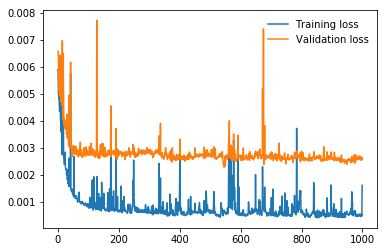

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


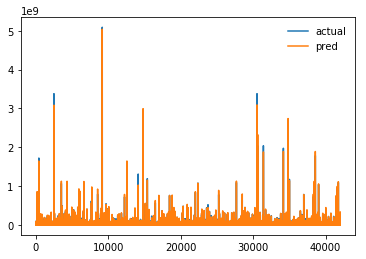

In [21]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [22]:
pred = test_func(model, X_test)


In [23]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.398167e+07
1,BTshNOJyKHnT2YIT,5.928512e+05
2,dhdymr0lV8N5kZOT,1.154590e+07
3,VEwyGGMcD56w5BOc,1.611052e+06
4,wmUeMoJZfsqaSX9b,5.928512e+05
5,EtBjGAHmHCe9t7TZ,5.928512e+05
6,hPNH34vmaZtvBtqc,1.299164e+07
7,wXjeI38bYDMJJwZC,4.951337e+06
8,fxZSGX6aPAFKU8W4,5.928512e+05
9,ewr0Fx6ign87OwaV,1.045293e+06


## overfitting

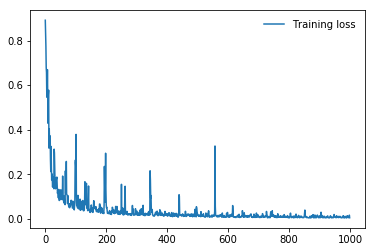

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

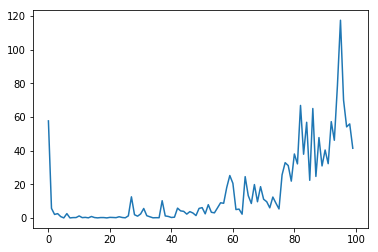

In [19]:
plt.plot(eval_losses, label='Validation loss')


## overfitting2

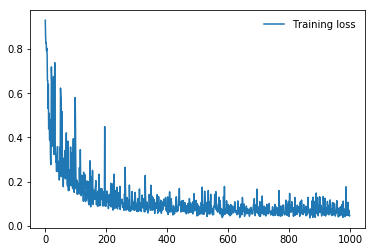

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

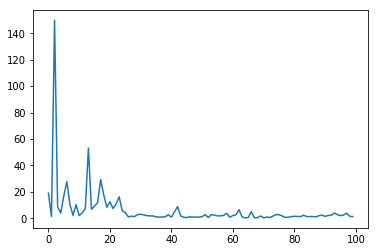

In [19]:
plt.plot(eval_losses, label='Validation loss')


### Submission

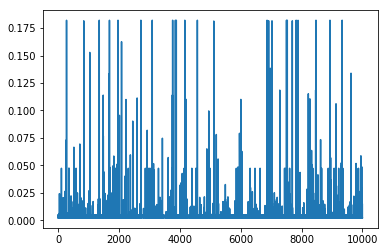

In [26]:
plt.plot(pred, label='pred')


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512

Result 2 lr=0.001, batch_size=64, DNN 233->256->128->64->1
after 1k loss : 0.00011785521522113447, can't decrease...
- x_scale false
- y_scale true

Result 3 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->1
after 1w loss : 0.0003, test loss : 0.0007 score: 16000


### question

why output is negative?